In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [6]:
# Define the ticker symbol for DJIA
ticker = "^DJI"

# Download historical data from Yahoo Finance
df = yf.download(ticker, start="2000-01-01", end="2024-01-01")

# Display the first few rows of the dataframe
print(df.info())

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6037 non-null   float64
 1   High       6037 non-null   float64
 2   Low        6037 non-null   float64
 3   Close      6037 non-null   float64
 4   Adj Close  6037 non-null   float64
 5   Volume     6037 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 330.1 KB
None


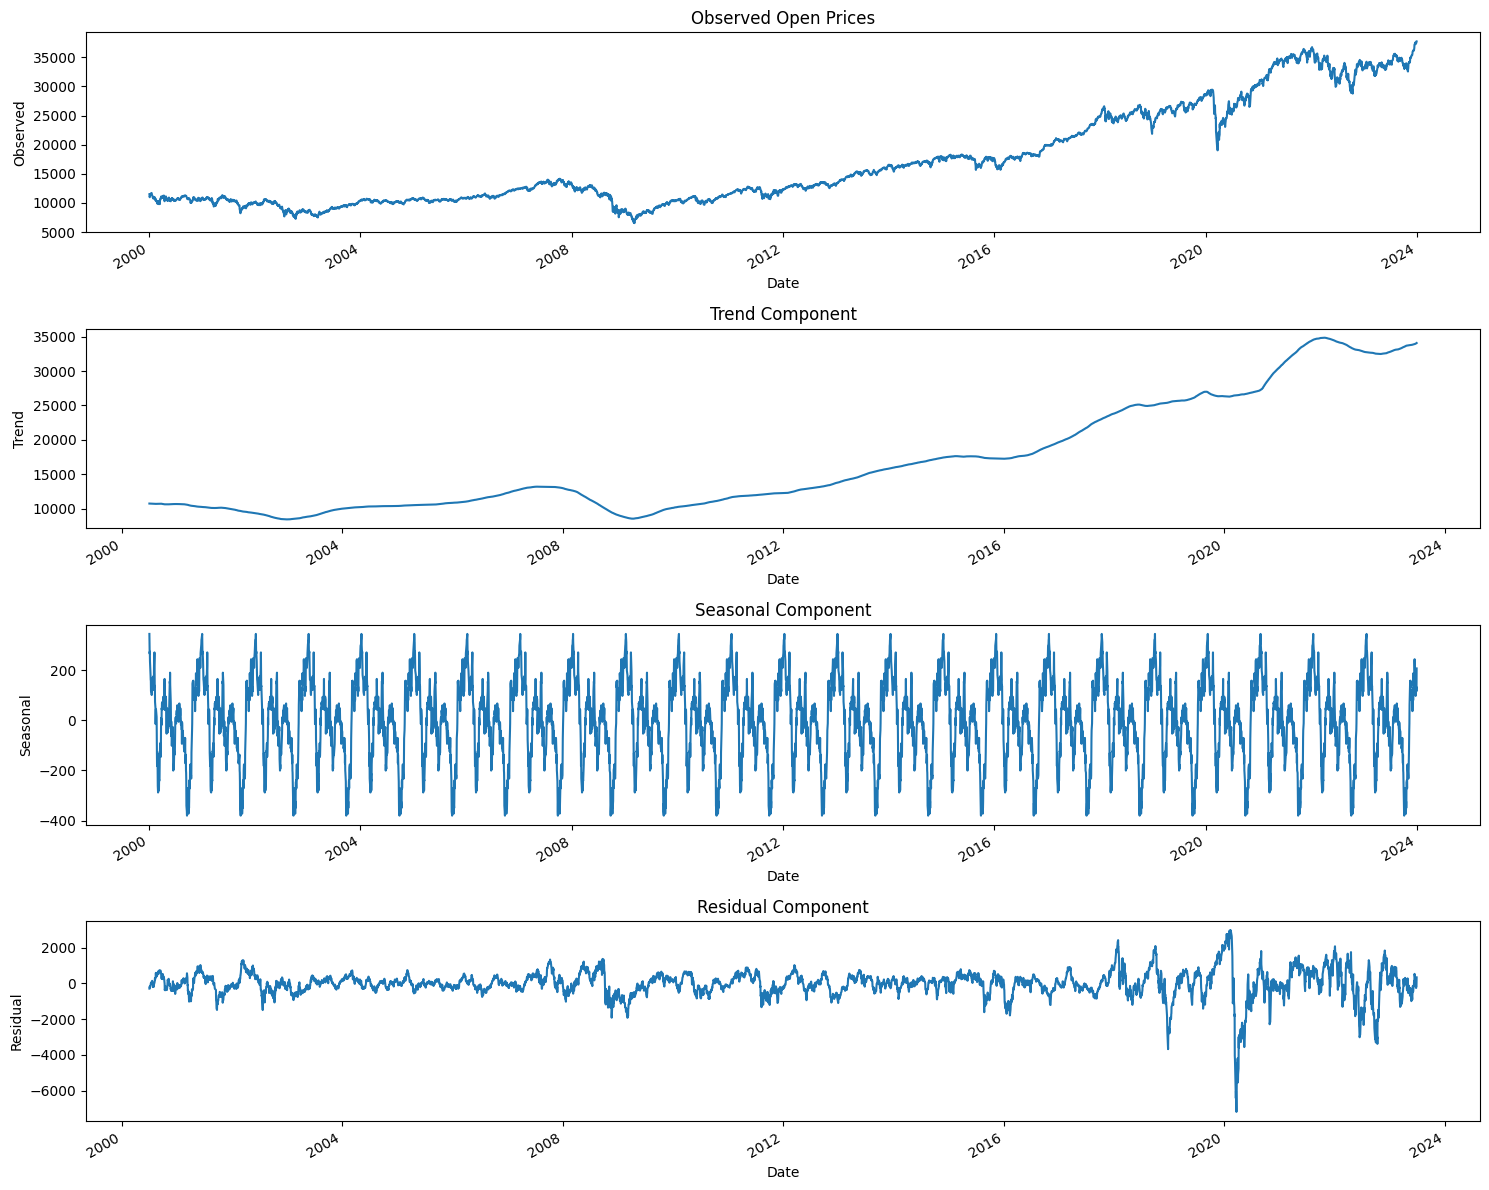

In [7]:
# Ensure the data is sorted by date
df_time = df.sort_index()

# Perform time series decomposition on the open price
open_price = df_time['Open']
result = seasonal_decompose(open_price, model='additive', period=252)  # Assuming 252 trading days in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Observed
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed Open Prices')

# Trend
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend Component')

# Seasonal
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal Component')

# Residual
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()

### Adding more features

In [8]:
# Calculate Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
df['SMA_50'] = df['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()  # 12-day Exponential Moving Average
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()  # 26-day Exponential Moving Average

# Calculate RSI
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Handle missing values by filling forward
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Display the updated DataFrame with new features
print(df.head())

                    Open          High           Low         Close  \
Date                                                                 
2000-03-14   9957.669922  10043.299805   9811.240234   9811.240234   
2000-03-15   9808.150391  10180.200195   9776.490234  10131.410156   
2000-03-16  10139.580078  10632.459961  10138.339844  10630.599609   
2000-03-17  10629.980469  10763.379883  10567.309570  10595.230469   
2000-03-20  10594.750000  10727.709961  10586.990234  10680.240234   

               Adj Close     Volume        SMA_20        SMA_50        EMA_12  \
Date                                                                            
2000-03-14   9811.240234  186080000  10142.845068  10733.097598  10025.573267   
2000-03-15  10131.410156  204920000  10113.511084  10708.575605  10041.855865   
2000-03-16  10630.599609  253790000  10116.970557  10701.229004  10132.431826   
2000-03-17  10595.230469  247830000  10121.003564  10690.680605  10203.631617   
2000-03-20  10680.24023

C:\Users\Ranojoy Deb\AppData\Local\Temp\ipykernel_4444\3766073019.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame with the same column names
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

# Display the first few rows of the scaled data
print(scaled_df.head())

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2000-03-14 -0.854304 -0.852154 -0.863497 -0.872133  -0.872133 -0.498009   
2000-03-15 -0.872242 -0.835805 -0.867687 -0.833727  -0.833727 -0.332419   
2000-03-16 -0.832479 -0.781795 -0.824063 -0.773845  -0.773845  0.097111   
2000-03-17 -0.773644 -0.766160 -0.772348 -0.778088  -0.778088  0.044727   
2000-03-20 -0.777870 -0.770420 -0.769975 -0.767891  -0.767891 -0.571399   

              SMA_20    SMA_50    EMA_12    EMA_26       RSI      MACD  \
Date                                                                     
2000-03-14 -0.831336 -0.757814 -0.846108 -0.816835 -0.924463 -1.307858   
2000-03-15 -0.834873 -0.760790 -0.844149 -0.818012 -0.206780 -1.180552   
2000-03-16 -0.834455 -0.761682 -0.833249 -0.814637  0.724955 -0.874298   
2000-03-17 -0.833969 -0.762962 -0.824681 -0.811828  0.498320 -0.639860   
2000-03-20 -0.831192 -0.764354

### Create the Environment

In [26]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.asset = 0
        self.net_worth = self.initial_balance
        self.transaction_cost = 0.001  # Example transaction cost (0.1%)
        self.max_position_size = 100000  # Limit on position size

        # Define the action space (Hold, Buy, Sell)
        self.action_space = spaces.Discrete(3)

        # Observation space: balance, asset, net worth, SMA, RSI, MACD
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # History tracking
        self.balance_history = []
        self.asset_history = []
        self.net_worth_history = []

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.asset = 0
        self.net_worth = self.initial_balance
        self.balance_history = [self.balance]
        self.asset_history = [self.asset]
        self.net_worth_history = [self.net_worth]
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            self.balance, 
            self.asset, 
            self.net_worth,
            self.df.iloc[self.current_step]['SMA_20'],
            self.df.iloc[self.current_step]['RSI'],
            self.df.iloc[self.current_step]['MACD']
        ])
        return obs.astype(np.float32)

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        self.current_step += 1

        prev_net_worth = self.net_worth

        if action == 1:  # Buy
            if self.balance > 0:
                amount_to_buy = min(self.balance, self.max_position_size)
                self.asset += (amount_to_buy * (1 - self.transaction_cost)) / current_price
                self.balance -= amount_to_buy

                # Prevent negative asset value due to transaction costs
                if self.asset < 0:
                    self.asset = 0

        elif action == 2:  # Sell
            if self.asset > 0:
                sell_amount = self.asset * current_price * (1 - self.transaction_cost)
                self.balance += sell_amount
                self.asset = 0

        self.net_worth = self.balance + self.asset * current_price

        # Ensure balance doesn't go negative
        if self.balance < 0:
            self.balance = 0
            self.net_worth = self.asset * current_price

        # Ensure net worth doesn't go negative
        if self.net_worth < 0:
            self.net_worth = prev_net_worth

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Record history
        self.balance_history.append(self.balance)
        self.asset_history.append(self.asset)
        self.net_worth_history.append(self.net_worth)

        done = self.current_step >= len(self.df) - 1

        obs = self._next_observation()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Asset: {self.asset}')
        print(f'Net Worth: {self.net_worth}')


### Trading Agent(s)

#### Q-Learning Agent

In [27]:
class QLearningAgent:
    def __init__(self, state_bins, action_size):
        self.state_bins = state_bins
        self.action_size = action_size
        self.q_table = np.zeros(tuple(len(bins) + 1 for bins in state_bins) + (action_size,))
        self.learning_rate = 0.1
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def discretize_state(self, state):
        state_indices = []
        for i, value in enumerate(state):
            state_index = np.digitize(value, self.state_bins[i]) - 1
            state_indices.append(state_index)
        return tuple(state_indices)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

#### DQN Agent

In [28]:
# Step 6: Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)  # Reduce memory size
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 12),  # Reduce network complexity
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return np.argmax(act_values.detach().numpy())

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state)
                target = reward + self.gamma * torch.max(self.model(next_state)).item()

            state = torch.FloatTensor(state)
            current_q_values = self.model(state)
            target_q_values = current_q_values.clone().detach()
            target_q_values[action] = target

            # Perform the backward pass and update the weights
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(current_q_values, target_q_values)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


### Train the Trading Bot

In [32]:
# Create the environment
env = TradingEnv(scaled_df)

# Reset the environment
state = env.reset()

# Take a sample step
action = env.action_space.sample()  # Random action (for illustration)
next_state, reward, done, _ = env.step(action)

# Render the environment
env.render()

Step: 1
Balance: 10000
Asset: 0
Net Worth: 10000.0


#### Train the Q-learning Bot

In [30]:
# Initialize Environment and Agent for Q-Learning
env_qlearning = TradingEnv(scaled_df)

state_bins = [
    np.linspace(0, env_qlearning.initial_balance * 2, 20),  # Balance bins
    np.linspace(0, env_qlearning.initial_balance * 2, 20),  # Asset bins
    np.linspace(0, env_qlearning.initial_balance * 2, 20),  # Net worth bins
    np.linspace(-5, 5, 20),                                 # SMA_20 bins
    np.linspace(0, 100, 20),                                # RSI bins
    np.linspace(-5, 5, 20)                                  # MACD bins
]

agent_qlearning = QLearningAgent(state_bins, env_qlearning.action_space.n)

# Train the Q-learning Agent
num_episodes_qlearning = 100

for episode in range(num_episodes_qlearning):
    state = agent_qlearning.discretize_state(env_qlearning.reset())
    done = False
    total_reward = 0

    while not done:
        action = agent_qlearning.choose_action(state)
        next_state, reward, done, _ = env_qlearning.step(action)
        next_state = agent_qlearning.discretize_state(next_state)
        agent_qlearning.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    print(f"Q-Learning Episode {episode + 1}: Total Reward: {total_reward}")

Q-Learning Episode 1: Total Reward: -10000.0
Q-Learning Episode 2: Total Reward: -10000.0
Q-Learning Episode 3: Total Reward: -10000.0
Q-Learning Episode 4: Total Reward: -10000.0
Q-Learning Episode 5: Total Reward: -10000.0
Q-Learning Episode 6: Total Reward: -10000.0
Q-Learning Episode 7: Total Reward: -10000.0
Q-Learning Episode 8: Total Reward: -10000.0
Q-Learning Episode 9: Total Reward: -10000.0
Q-Learning Episode 10: Total Reward: -10000.0
Q-Learning Episode 11: Total Reward: -10000.0
Q-Learning Episode 12: Total Reward: -10000.0
Q-Learning Episode 13: Total Reward: -10000.0
Q-Learning Episode 14: Total Reward: -10000.0
Q-Learning Episode 15: Total Reward: -10000.0
Q-Learning Episode 16: Total Reward: -10000.0
Q-Learning Episode 17: Total Reward: -10000.0
Q-Learning Episode 18: Total Reward: -10000.0
Q-Learning Episode 19: Total Reward: -10000.0
Q-Learning Episode 20: Total Reward: -10000.0
Q-Learning Episode 21: Total Reward: -10000.0
Q-Learning Episode 22: Total Reward: -10000

KeyboardInterrupt: 

#### Train the DQN Bot

In [ ]:
# Initialize Environment and Agent for DQN
env_dqn = TradingEnv(scaled_df)
state_size = env_dqn.observation_space.shape[0]
action_size = env_dqn.action_space.n
agent_dqn = DQNAgent(state_size, action_size)
batch_size = 16  # Reduce batch size
num_episodes_dqn = 50  # Reduce number of episodes

# Train the DQN Agent
for e in range(num_episodes_dqn):
    state = env_dqn.reset()
    total_reward = 0

    for time in range(200):  # Reduce the number of steps per episode
        action = agent_dqn.act(state)
        next_state, reward, done, _ = env_dqn.step(action)
        total_reward += reward
        agent_dqn.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"DQN Episode {e + 1}/{num_episodes_dqn}, Reward: {total_reward}, Epsilon: {agent_dqn.epsilon}")
            break

        if len(agent_dqn.memory) > batch_size:
            agent_dqn.replay(batch_size)

In [ ]:
# Performance Metrics Calculation
def calculate_metrics(balance_history, initial_balance=10000):
    balance_series = pd.Series(balance_history)
    returns = balance_series.pct_change().dropna()

    # Sharpe Ratio
    risk_free_rate = 0.0
    average_return = returns.mean()
    std_dev = returns.std()
    sharpe_ratio = (average_return - risk_free_rate) / std_dev if std_dev != 0 else 0

    # Cumulative Returns
    cumulative_returns = (balance_series.iloc[-1] / initial_balance) - 1

    # Maximum Drawdown
    rolling_max = balance_series.cummax()
    drawdown = (balance_series - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Cumulative Returns': cumulative_returns,
        'Maximum Drawdown': max_drawdown
    }

# Plotting Performance
def plot_performance(balance_history, asset_history, net_worth_history):
    plt.figure(figsize=(14, 7))
    plt.plot(balance_history, label='Balance')
    plt.plot(asset_history, label='Assets')
    plt.plot(net_worth_history, label='Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Trading Bot Performance')
    plt.legend()
    plt.show()

### Run the RL Trading Bot

#### Run Qlearning Bot

In [ ]:
# Run the Q-learning Agent in the Environment
state = agent_qlearning.discretize_state(env_qlearning.reset())
done = False

while not done:
    action = agent_qlearning.choose_action(state)
    next_state, reward, done, _ = env_qlearning.step(action)
    next_state = agent_qlearning.discretize_state(next_state)
    state = next_state

env_qlearning.render()
qlearning_metrics = calculate_metrics(env_qlearning.net_worth_history)
print(f"Q-Learning Performance: {qlearning_metrics}")

Step: 5987
Balance: 0
Asset: -11454.673659117103
Net Worth: 118.86041003865174
Q-Learning Performance: {'Sharpe Ratio': 0.039769443739668064, 'Cumulative Returns': -0.9881139589961349, 'Maximum Drawdown': -0.9998041457787801}


#### Run DQN Bot

In [ ]:
# Run the DQN Agent in the Environment
state = env_dqn.reset()
done = False
dqn_rewards = []

while not done:
    action = agent_dqn.act(state)
    next_state, reward, done, _ = env_dqn.step(action)
    state = next_state
    dqn_rewards.append(reward)

env_dqn.render()
print(f"DQN Total Reward: {np.sum(dqn_rewards)}")

Step: 5987
Balance: 0
Asset: -12721.718696084497
Net Worth: 132.0080122413138
DQN Total Reward: -9867.991987758687


### Performance Metrics Calculation

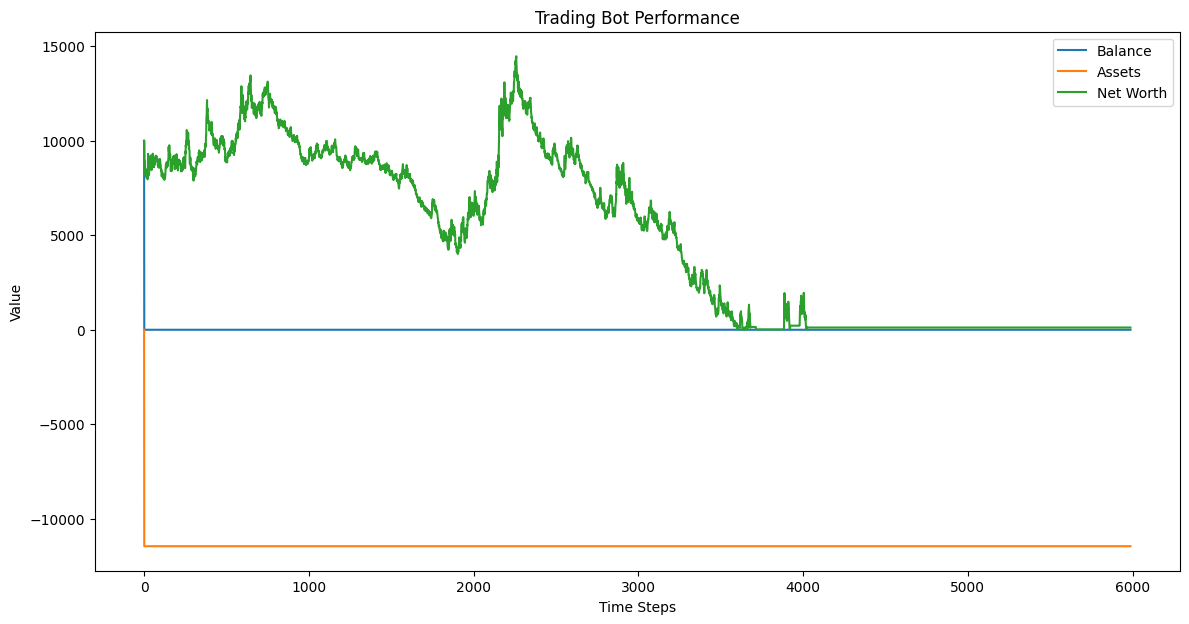

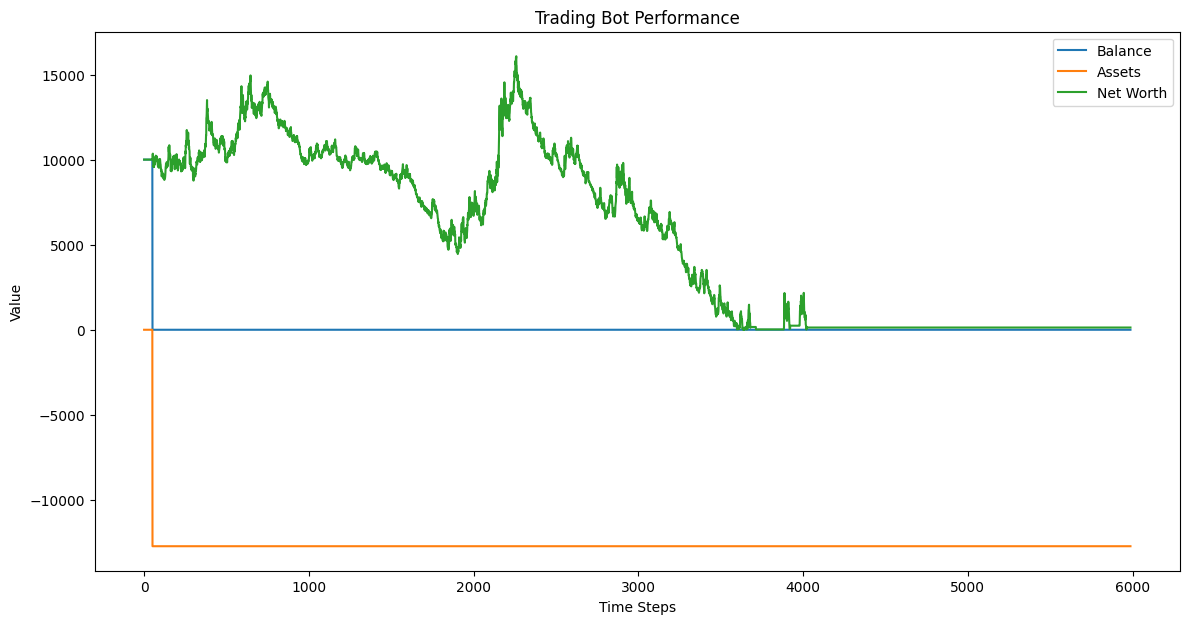

In [ ]:
# Plot performance for Q-Learning
plot_performance(env_qlearning.balance_history, env_qlearning.asset_history, env_qlearning.net_worth_history)

# Plot performance for DQN
plot_performance(env_dqn.balance_history, env_dqn.asset_history, env_dqn.net_worth_history)